# DSC-212 Semester Assignment

This notebook outlines a semi-general approach to identifying and modeling the various communities present in the well known Karate Club graph. I say semi-general because the mathematics behind it is applicable to any and all undirected graphs without edge weights but the implementation done here is tailor-made and customized for the karate club graph specifically.  

The program was made through the use of the following libraries:

In [34]:
import networkx as nx
import matplotlib.pyplot as mp
import numpy as np

The code is as follows which shall be documented memberwise through the use of comments. 

In [35]:
colour_map = ['red','blue','green','orange','purple','darkgreen','lightcoral'] # Arbitrarily sized colour template from which we shall colour our communities
q = 0                                                                          # Global terative variable defined for ease of graph rendering
G = nx.karate_club_graph()                                                     # Karate club graph initialized
count = 0                                                                      # Global iterative variable defined for ease of graph splitting
colour = [0 for i in range(34)]                                                # Empty list which shall be filled with the convention such that the colour at the i-th index represents the colour of the i-th node, which by extension represents the colour of it's community
F = G                                                                          # Copy of G to allow visualisation after each split
Q = []                                                                         # List containing modularity of the graph after each iteration
com = dict.fromkeys(list(nx.nodes(G)))                                         # List defined to represent the community the i-th node belongs to through the use of integers at the i-th index in the list
it_data = dict.fromkeys(list(nx.nodes(G)))                                     # Dictionary containing data about which node belonged to which community for each iteration
for i in nx.nodes(G):                                                          # Initialization of dictionary and list
    com[i] = -1
    it_data[i] = [(0,"null")]


Functions to compute modularity and community identification through the use of spectral decomposition

In [36]:
def modularity(g):                                                                 # Function to compute modularity
    k = np.array(g.degree)
    A = nx.adjacency_matrix(g)
    k = k[:,1]
    k = k[:, np.newaxis]
    k_t = k.T
    K = k @ k_t
    a = np.sum(k)
    K = K/a
    B = (A - K)
    l, u = np.linalg.eig(B)
    s = u[:,list(l).index(np.max(l))]
    s = s[:, np.newaxis]
    s_T = s.T
    Q.append((1/(2*a))*float((s_T @ B @ s)[0,0].real))

def identify(g):                                                               # Function to partition a given graph into sets of two points based on the community they belong to through spectral decomposition
    global count
    count = 0
    k = np.array(g.degree)
    A = nx.adjacency_matrix(g)
    k = k[:,1]
    k = k[:, np.newaxis]
    k_t = k.T
    K = k @ k_t
    a = np.sum(k)
    K = K/a
    B = (A - K)
    l, u = np.linalg.eig(B)
    ind = 0
    s = u[:,list(l).index(np.max(l))]
    for i in range(len(s)):
        if s[i].imag != 0:
            s[i] = float(0)
        else:
            s[i] = float(s[i].real)
    for i in list(g.nodes()):
        if s[ind]>0:
            com[i]=count
        else:
            com[i]=count+1
        ind = ind + 1
    count = count + 2

The following functions perform various smaller operations which allowed the code to be neatly modularized where the functions can be called as needed.

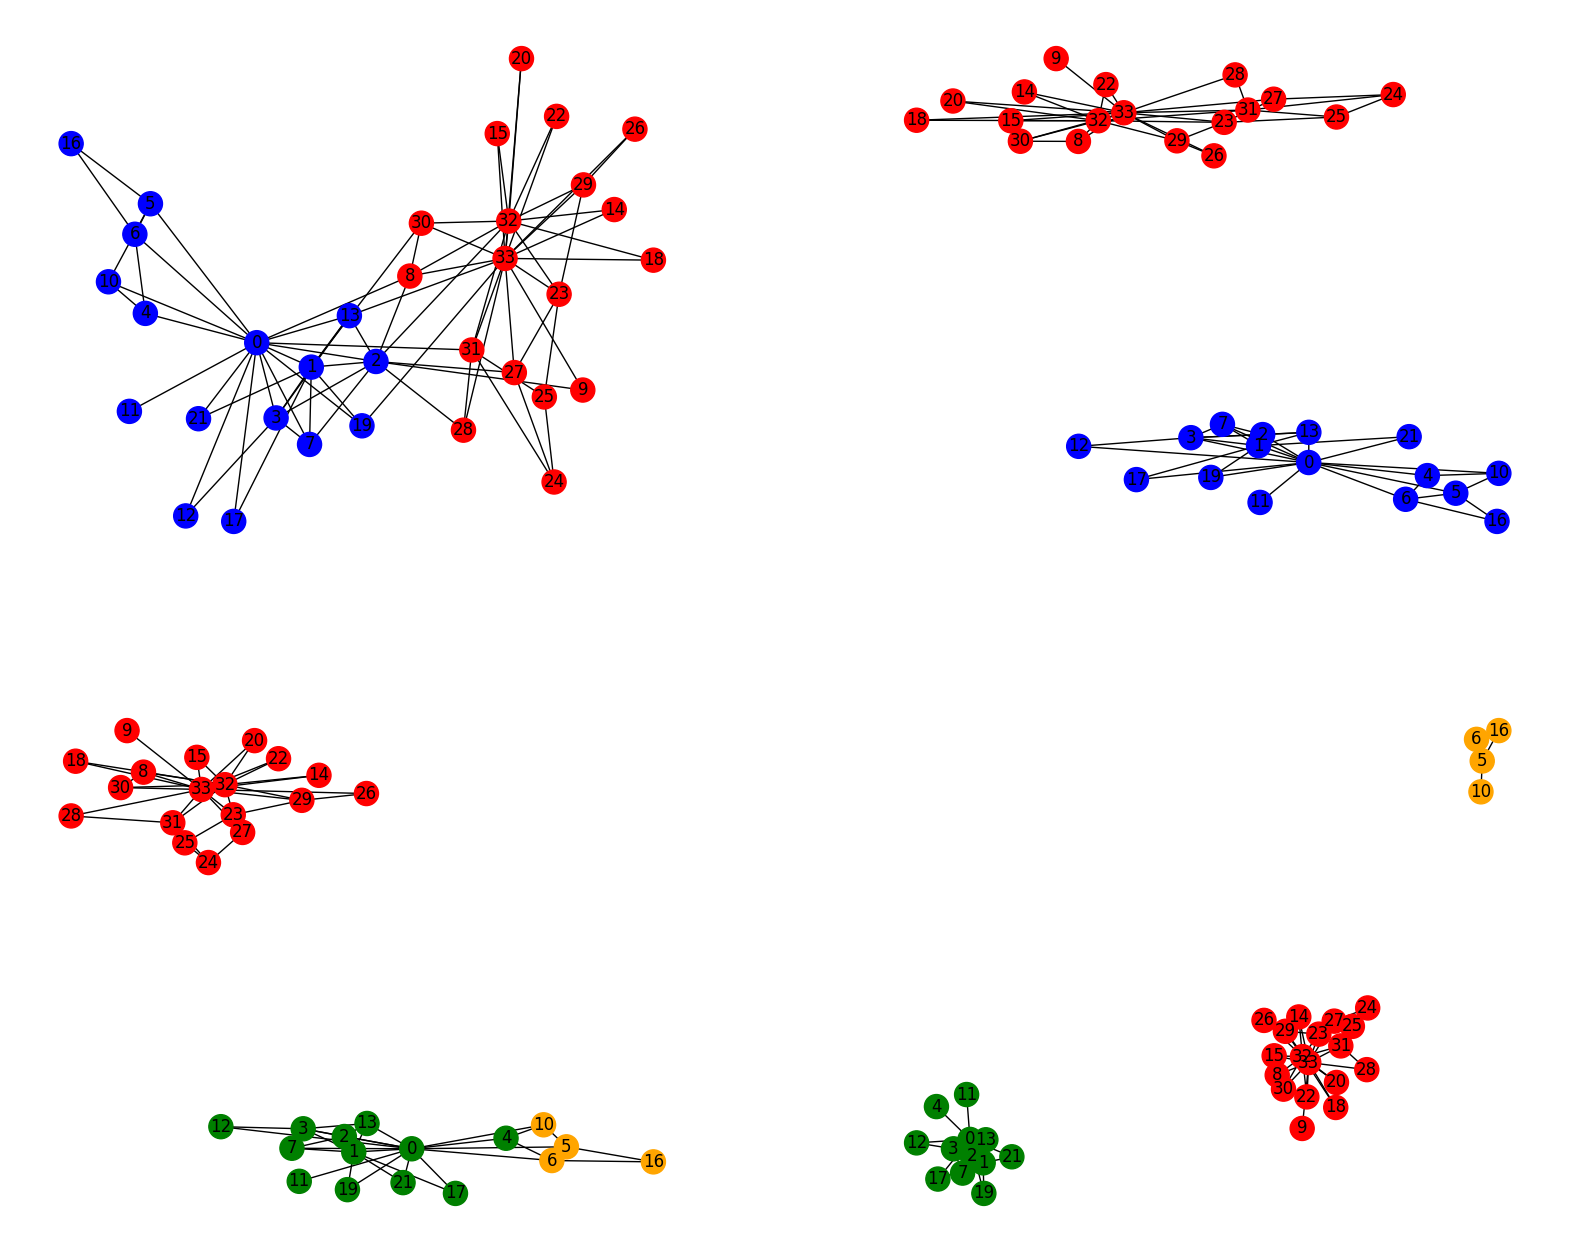

In [37]:
def partition(f):                                                              # Function the split given graph into two subgraphs where each is a community
    l1 = []
    l2 = []
    for i in nx.nodes(f):
        if com[i]%2 == 0:
            l1.append(i)
        else:
            l2.append(i)
    f_1 = nx.subgraph(f, l1)
    f_2 = nx.subgraph(f, l2)
    return f_1,f_2

def update(g, color):                                                          # Function to update the colour a set of nodes are supposed to be
    for i in nx.nodes(g):
        it_data[i].append((it_data[i][-1][0]+1,color))

def terminal(g):                                                               # Function to determine if anymore communities can be formed in the given graph
    if(nx.is_empty(g)==True):
        return 0
    t = []
    for i in nx.nodes(g):
        t.append(com[i])
    p = set(t)
    return len(p)

def edge_cut(a, b):                                                            # Function to isolate communities in the graph F
    for i in nx.nodes(a):
        for j in nx.nodes(b):
            if (i,j) in nx.edges(F):
                F.remove_edge(i, j)

mp.figure(figsize=(20, 16))                                                    # Predefining the plotting figure size

def REC(g):                                                                    # Recursive function to identify communities
    if nx.is_empty(g)==True:
        return 0
    else:
        global q
        global colour
        identify(g)
        a, b = partition(g)
        identify(a)
        identify(b)
        update(a,"blue")
        update(b,"red")
        for i in nx.nodes(G):
            if i in nx.nodes(a):
                colour[i] = colour_map[q]
            if i in nx.nodes(b):
                colour[i] = colour_map[q+1]

        subax1 = mp.subplot(2, 2, q+1)
        nx.draw_spring(F, with_labels = True, node_color = colour)

        edge_cut(a, b)
        modularity(F)
        
        subax2 = mp.subplot(2,2,q+2)
        nx.draw_spring(F, with_labels = True, node_color = colour)

        q += 2
        
        if nx.is_empty(a)==False and terminal(a)!=1:
            REC(a)
        if nx.is_empty(b)==False and terminal(b)!=1:
            REC(b)

modularity(G)                                                              # Computing modularity of G first so that the 0-th index of Q corresponds to the original graph
REC(G)                                                                     # Executing the recursion to split the graph and visualize the split at each iteration

In the figures above, the graph G has been split and visualized after each iteration.
The top left corner represents the initial graph with just the communities visualized and drawn. The figure to the side of it depicts the graph after the aforementioned split where we can clearly see the various coloured nodes be a part of different communities. 

In the subsequent step, the nodes in the previously "red" community were found to be a "terminal community" i.e. they could no longer be split into further communities in a meaningful way which increases modularity hence they were left as is. The "blue" community however was successfully split and is depicted in the bottom left figure with the two communities identified being "green" and "yellow" respectively and the "red" community is clearly left as is. The bottom right figure finally depicts the graph after all possible splits have been done with each community being a "terminal community"

The rest of the notebook now focuses on studying the splitting and various communities formed here.

Here we define the dictionaries which contain the iteration number as keys and various graph metrics as data.

In [38]:
for i in it_data.keys():
    it_data[i].pop(0)

depth = 0

for i in it_data.keys():
    x = len(it_data[i])
    if x > depth:
        depth = x

colour_dict = {key: [] for key in range(1,depth+1)}
deg_c = dict.fromkeys(range(1,depth+1))
bet_c = dict.fromkeys(range(1,depth+1))
clo_c = dict.fromkeys(range(1,depth+1))
clus_co = dict.fromkeys(range(1,depth+1))

The following function constructs the metrics defined above

In [39]:
def construct(D, d):                                                    
    temp = 0
    for i in range(1,d+1):
        red = []
        blue = []
        for j in D.keys():
            for k in D[j]:
                if k[0] == i:
                    if k[1] == "red":
                        red.append(j)
                        colour_dict[i].append(colour_map[temp])
                    else:
                        blue.append(j)
                        colour_dict[i].append(colour_map[temp+1])
        a = nx.subgraph(G, red)
        b = nx.subgraph(G, blue)
        y = nx.degree_centrality(a) | nx.degree_centrality(b)
        deg_c[i] = dict(sorted(y.items()))
        y = nx.betweenness_centrality(a) | nx.betweenness_centrality(b)
        bet_c[i] = dict(sorted(y.items()))
        y = nx.closeness_centrality(a) | nx.closeness_centrality(b)
        clo_c[i] = dict(sorted(y.items()))
        y = nx.clustering(a) | nx.clustering(b)
        clus_co[i] = dict(sorted(y.items()))
        temp += 2

construct(it_data, depth)

for i in nx.nodes(G):                                                           # Logic to allow the metrics for nodes in terminal communities to be carried on in further iterations. For example if node 7 was split in iteration 1 and then labeled part of a "terminal community" then in further iterations it should possess the same value for the various metrics and thus it's terminal value is carried forth into further iterations
    if i not in deg_c[2]:
        deg_c[2][i] = deg_c[1][i]
    if i not in bet_c[2]:
        bet_c[2][i] = bet_c[1][i]
    if i not in clo_c[2]:
        clo_c[2][i] = clo_c[1][i]
    if i not in clus_co[2]:
        clus_co[2][i] = clus_co[1][i]

Below, we plot the graph G as it was initially with the only exception being that the final communities we obtain are already highlighted. To the right we obtain the graph split for these communities.

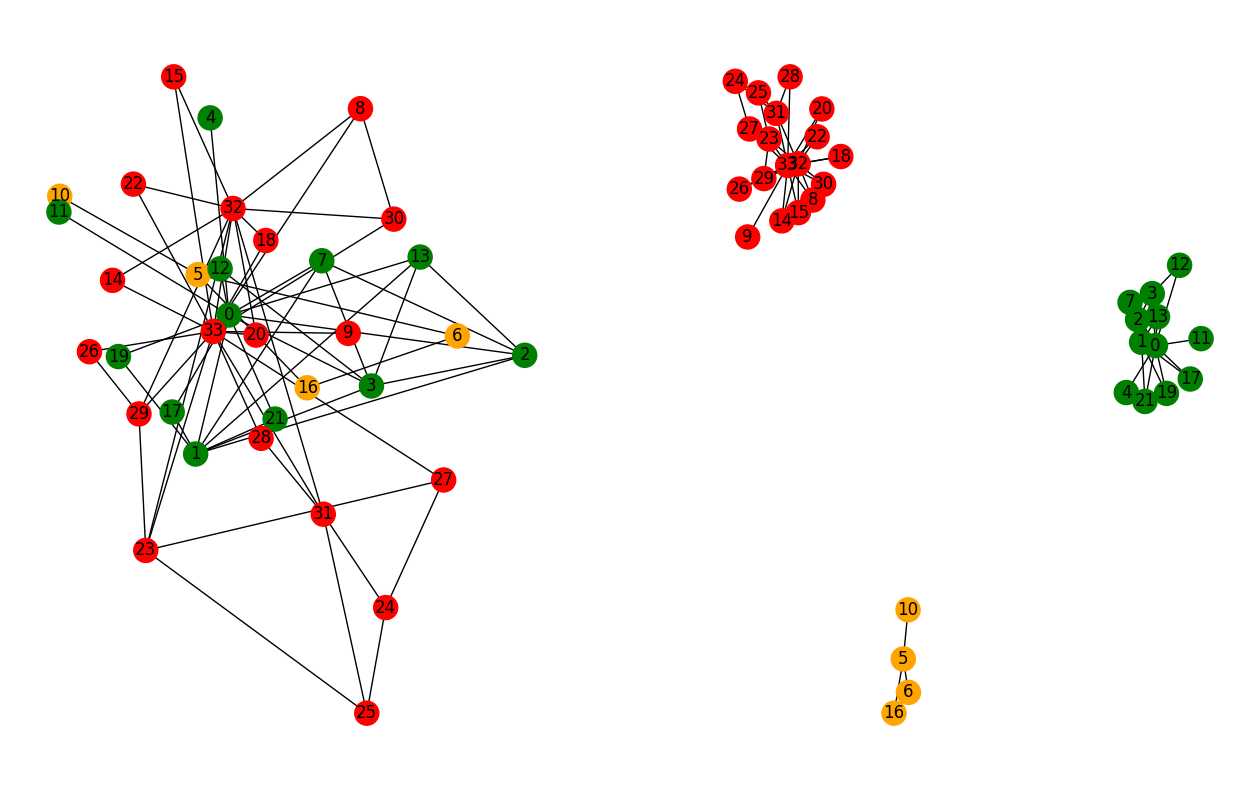

In [40]:
mp.figure(figsize=(16,10))

subax1 = mp.subplot(1,2,1)
nx.draw_kamada_kawai(G, with_labels = True, node_color = colour)

for i in nx.edges(G):
    if com[i[0]]!=com[i[1]]:
        G.remove_edge(i[0],i[1])

subax2 = mp.subplot(1,2,2)
nx.draw_spring(G, with_labels=True, node_color = colour)

The following blocks focus on graphically visualising the various metrics we measured as they evolve through iterations.

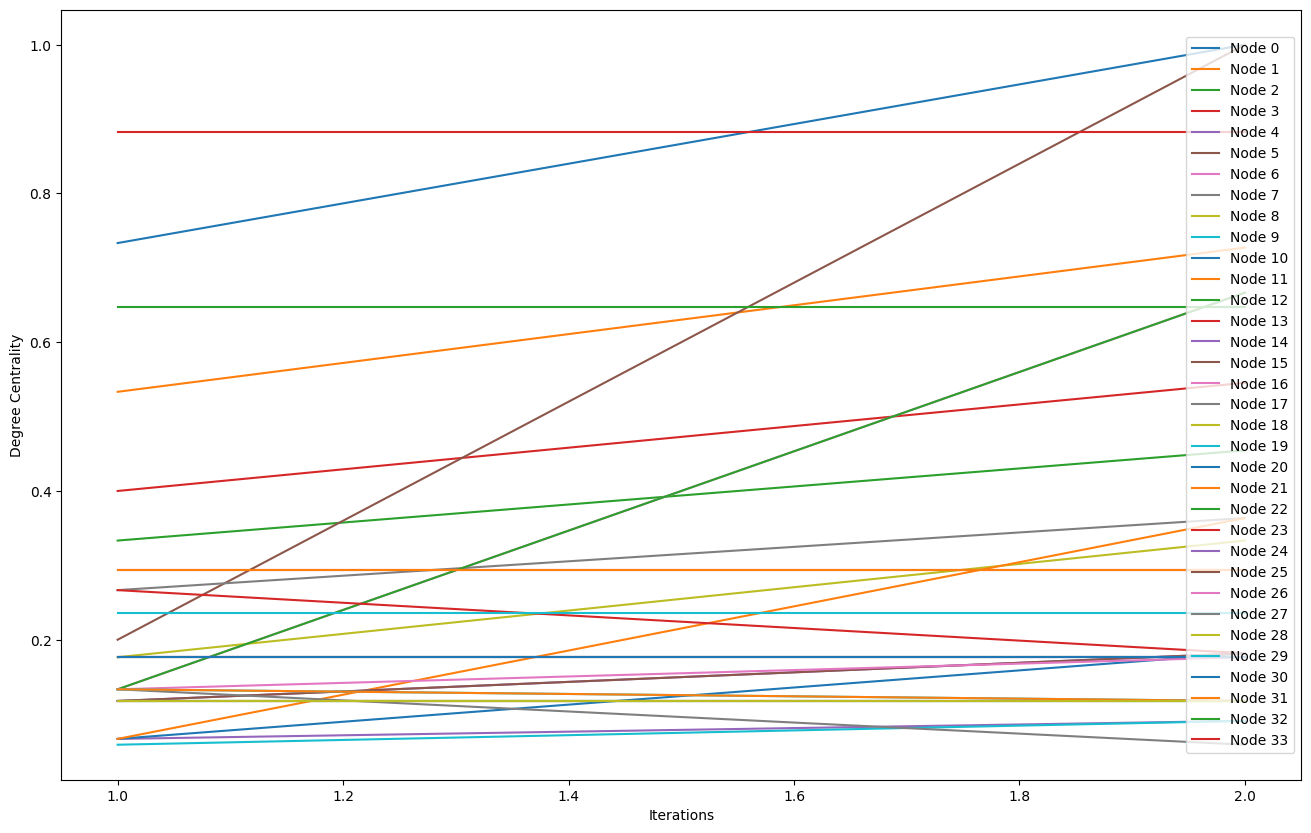

In [41]:
mp.figure(figsize=(16,10))

x = [1, 2]
y_1 = [deg_c[1][k] for k in deg_c[1].keys()]
y_2 = [deg_c[2][k] for k in deg_c[2].keys()]

for i in nx.nodes(G):
    y = [y_1[i], y_2[i]]
    mp.plot(x, y, label = f"Node {i}")

mp.xlabel('Iterations')
mp.ylabel('Degree Centrality')
mp.legend(loc = 'right')
mp.show()

The degree centrality of the various nodes is graph iteration-wise above.

Some interesting observations are of node 0,5, and 12 which show a sharp increase in their degree centrality with 0 and 5 especially reaching a degree centerality of 1 symbolizing that they are the "leaders" of their community along with node 33 consistently maintaining it's high degree centrality symbolizing it as already being an established "leader" of it's community.

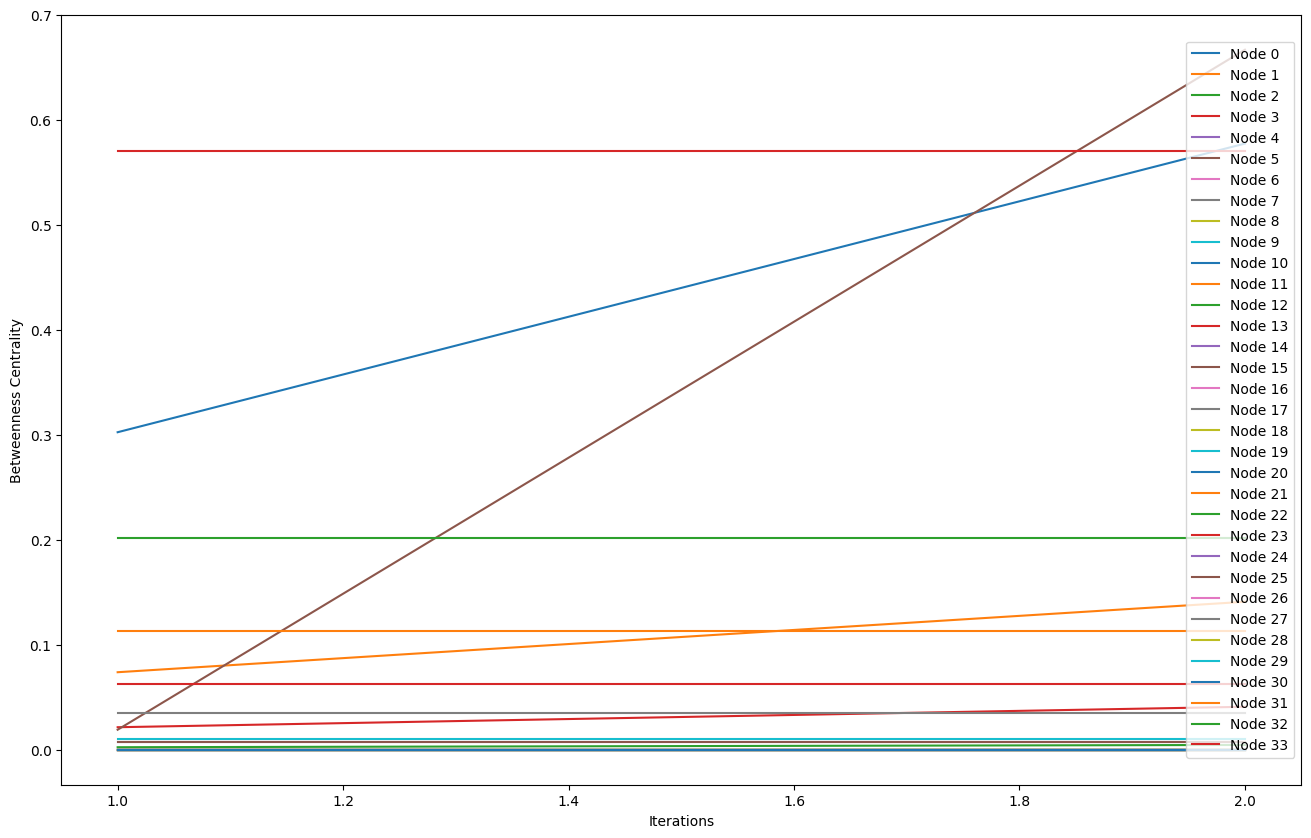

In [42]:
mp.figure(figsize=(16,10))

x = [1, 2]
y_1 = [bet_c[1][k] for k in bet_c[1].keys()]
y_2 = [bet_c[2][k] for k in bet_c[2].keys()]

for i in nx.nodes(G):
    y = [y_1[i], y_2[i]]
    mp.plot(x, y, label = f"Node {i}")

mp.xlabel('Iterations')
mp.ylabel('Betweenness Centrality')
mp.legend(loc = 'right')
mp.show()

The betweenness centrality largely remains constant for most nodes, as remain in their preferred communities and carry their same role and "connectedness" within it. The nodes which do have a change in this are, again, node 0 and 5 which separated from the initial graph to become leaders of their own community. In a sense large positive change in the betweenness centrality symbolizes "leaders" while no change symbolizes "followers".

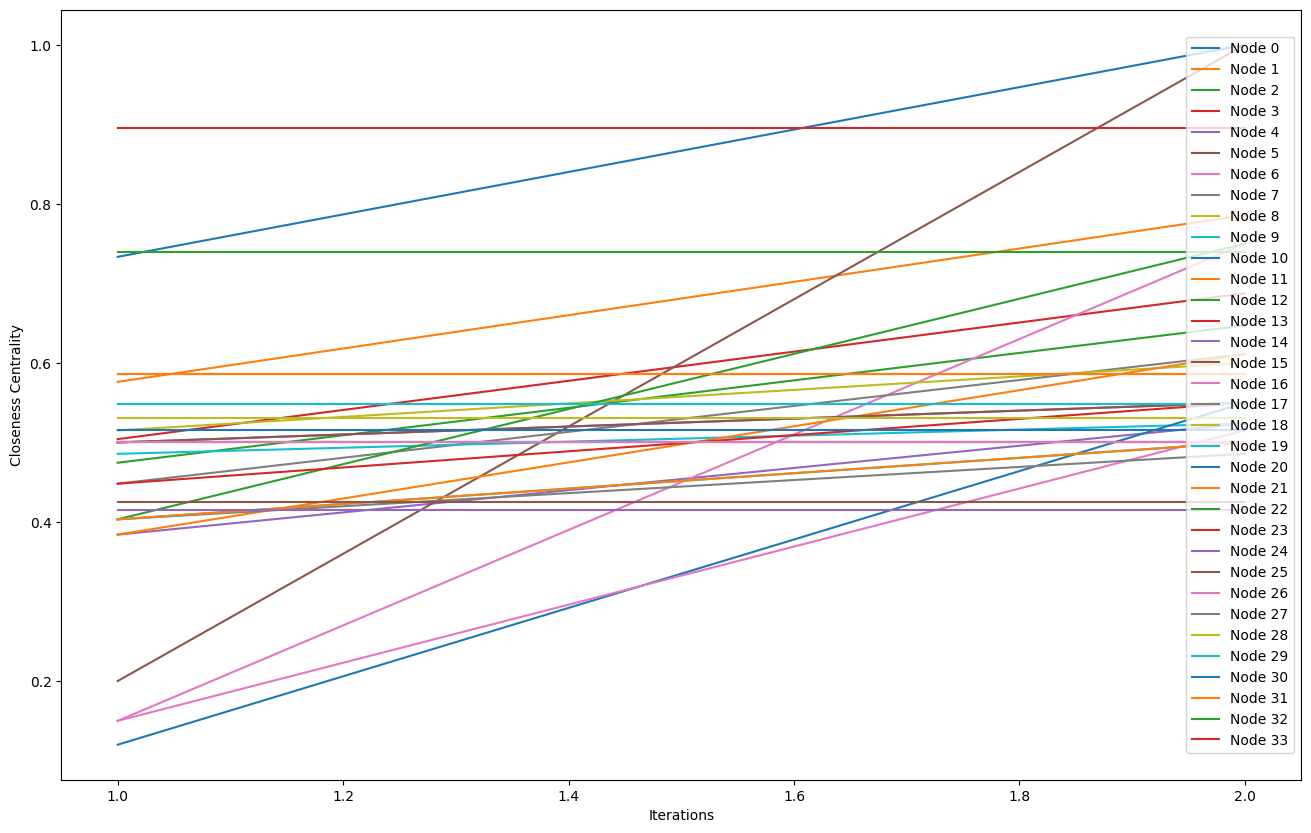

In [43]:
mp.figure(figsize=(16,10))

x = [1, 2]
y_1 = [clo_c[1][k] for k in clo_c[1].keys()]
y_2 = [clo_c[2][k] for k in clo_c[2].keys()]

for i in nx.nodes(G):
    y = [y_1[i], y_2[i]]
    mp.plot(x, y, label = f"Node {i}")

mp.xlabel('Iterations')
mp.ylabel('Closeness Centrality')
mp.legend(loc = 'right')
mp.show()

The closeness centrality is particularly interesting as it allows us to interpret which nodes have moved from communities they weren't significant members of to communities where they possess more "worth". For instance, node 5, 6, 10, and 16 depict a large increase in closeness centrality which can be observed in the graph as these nodes are a part of their own community where they each are a significant member. Neighbours of node 0 and 0 itself also show this albeit at a smaller scale. Members of the first community show no change in this metric signifying they already were important members of that community and remained there.

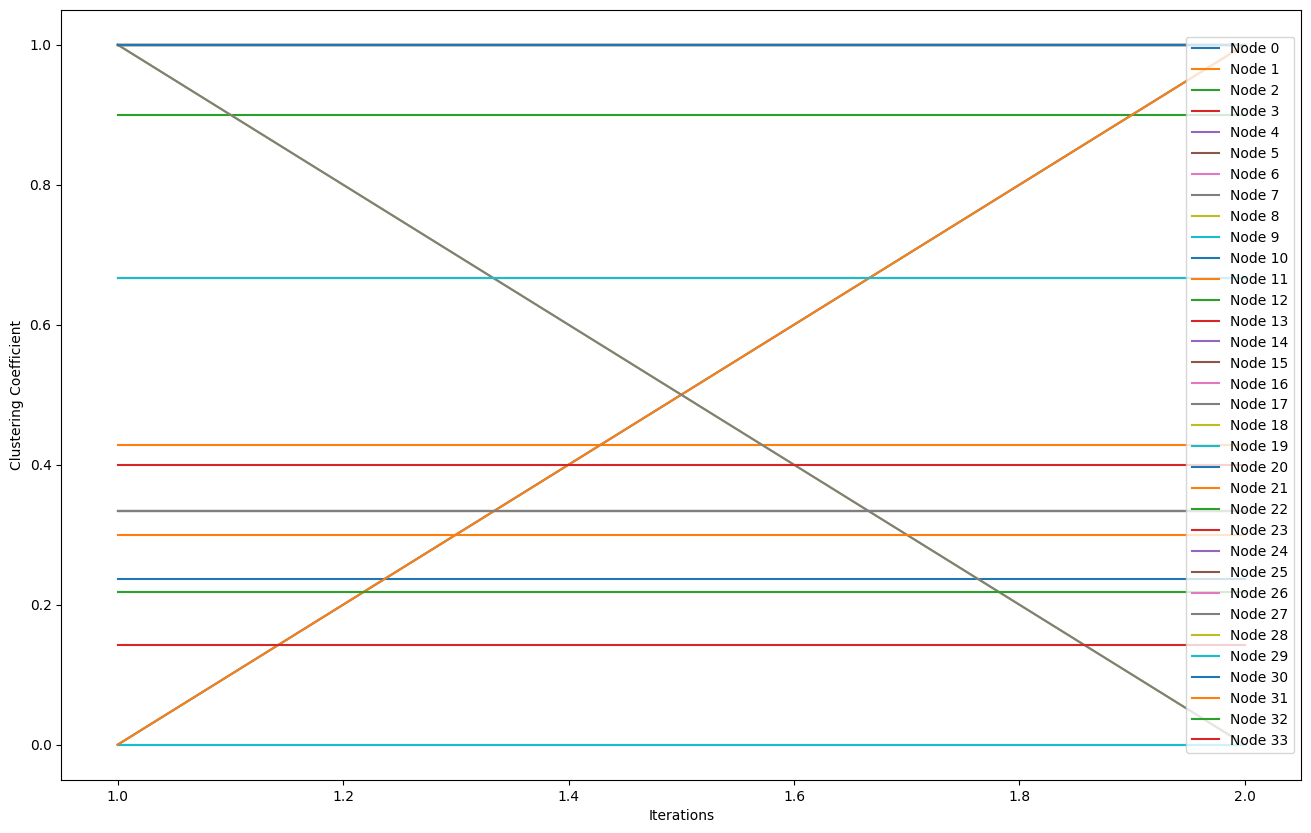

In [44]:
mp.figure(figsize=(16,10))

x = [1, 2]
y_1 = [clus_co[1][k] for k in clus_co[1].keys()]
y_2 = [clus_co[2][k] for k in clus_co[2].keys()]

for i in nx.nodes(G):
    y = [y_1[i], y_2[i]]
    mp.plot(x, y, label = f"Node {i}")

mp.xlabel('Iterations')
mp.ylabel('Clustering Coefficient')
mp.legend(loc = 'right')
mp.show()

The clustering coefficient of node 8 and 17 (not distinguishable since their lines overlap) shows a remarkable decrease from 1.0 all the way to 0.0 while that of node 10 and 11 show the exact opposite, from 0.0 to 1.0 which signifies that node 8 and 17 went from a significant part of their clusters to being outliers of the split community while 10 and 11 went from being outliers of their clusters to significant members of their clusters.

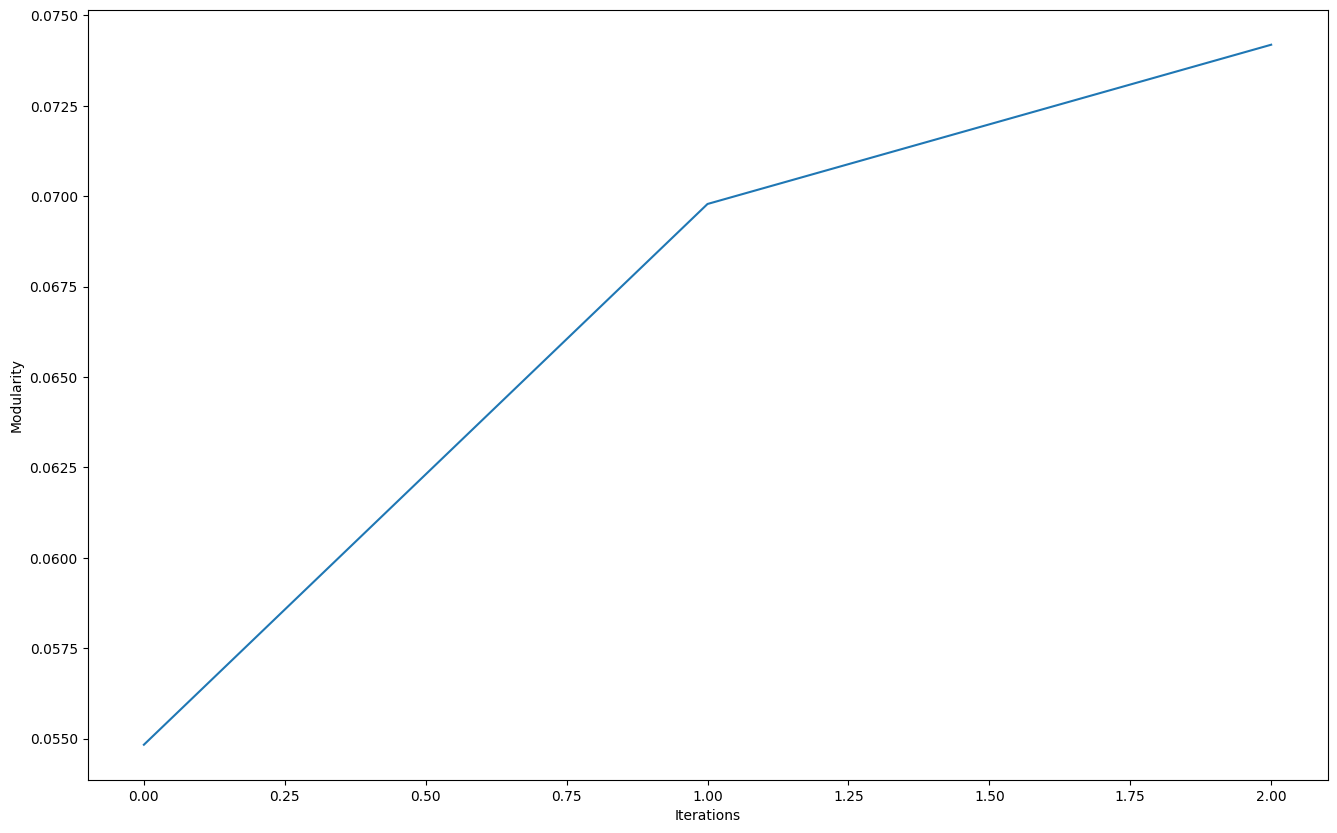

In [45]:
mp.figure(figsize=(16,10))

x = [0, 1, 2]
mp.plot(x, Q)
mp.xlabel('Iterations')
mp.ylabel('Modularity')
mp.show()

Here, we can see the modularity steadily increasing with each iteration with the very first iteration yielding the largest increase with subsequent ones leading to diminishing returns.